In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from hembedder.utils import distance, hyperparameter_tuning, quality_metrics


import umap
from umap.parametric_umap import ParametricUMAP
import phate
import ivis
import pacmap

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS

import gc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.chdir('T:/laupodteam/AIOS/Bram/data')

# Load data

This is imputed CELLDYN with combined variables.

In [3]:
celldyn_raw = pd.read_feather("./CellDyn/celldyn.feather")
celldyn_raw.columns = celldyn_raw.columns.str.lower()
fail_columns = [c for c in celldyn_raw.columns if 'fail' in c]
celldyn_raw = celldyn_raw.query('c_b_ht>0.2 and c_b_hb>0.2 and c_b_rbco>0.1 and c_b_rbco<100 and c_b_hb<20')
meas_columns_raw = [c for c in celldyn_raw.columns if 'c_b' in c]+['plt']
celldyn_raw['fcs_id'] = celldyn_raw['fcs_id'].str.decode('utf-8')
celldyn_raw = celldyn_raw.dropna(subset=meas_columns_raw)

In [4]:
celldyn_full = pd.read_feather("L:/laupodteam/AIOS/Bram/data/CellDyn/artifacts/celldyn_FULL_transformed_df.feather")
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c or 'COMBO_' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
demo_columns = ['gender', 'age']

In [5]:
celldyn_full_updated = pd.read_feather("./CellDyn/artifacts/celldyn_FULL_transformed_df_updated.feather")
replace_combos = {c: "COMBO_"+c for c in ['SII', 'NHL', 'NLR', 'PLR', 'HLR', 'LMR', 'WRR', 
                             'NWR', 'WPR', 'PRR', 'RHR', 'RIR', 'HHR',  'LSR',
                              'PMR', 'LPR', 'MHR', 'MMR']}
celldyn_full_updated = celldyn_full_updated.rename(columns=replace_combos)
meas_columns_update = [c for c in celldyn_full_updated.columns if 'c_b' in c or 'COMBO_' in c]

In [6]:
meta = pd.read_parquet("./CellDyn/artifacts/celldyn_labels.parquet")
meta = meta[~meta.dataset.isnull()]
meta = meta.rename(columns={'studyId_Alle_celldyn': 'studyid_alle_celldyn'})

In [7]:
meta = meta.assign(INFLAM=meta['dataset'].str.contains('MDL|REUMA'))
meta = meta.assign(HEART=meta['dataset'].str.contains('ARGUS|UCORBIO|HEARTSCORE'))
meta = meta.assign(BLOOD=meta['dataset'].str.contains('MDS|CLL'))
CCOLS=['INFLAM', 'HEART', 'BLOOD']

In [8]:
# append celldyn indices
celldyn_raw = celldyn_raw.merge(meta[['fcs_id', 'dataset']+CCOLS], on='fcs_id', how='left')
celldyn_full = celldyn_full.merge(meta[['studyid_alle_celldyn', 'afname_dt', 'dataset']+CCOLS],
                                   on=['studyid_alle_celldyn', 'afname_dt'], how='left')
celldyn_full_updated = celldyn_full_updated.merge(meta[['studyid_alle_celldyn', 'afname_dt', 'dataset']+CCOLS],
                                   on=['studyid_alle_celldyn', 'afname_dt'], how='left')

## Reduce dimensions

In [9]:
from keras import backend as K
from keras import Input, Model, Sequential
from keras.layers import Conv1D, Conv1DTranspose, AveragePooling1D, MaxPooling1D
from keras.layers import Dense, Flatten, Reshape, Dropout, BatchNormalization
from keras.layers import Activation, LeakyReLU, ReLU, Concatenate, Dropout, UpSampling1D

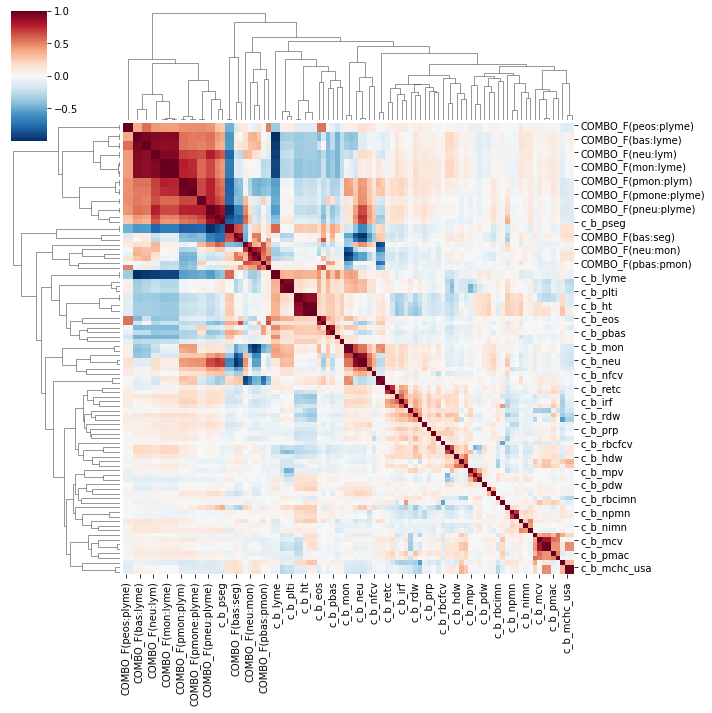

In [10]:
#celldyn_full_updated[meas_columns_update].median().hist(bins=25)
corr_matrix = celldyn_full.sample(50000)[meas_columns].corr(method='spearman')
sns.clustermap(corr_matrix, cmap='RdBu_r', center=0, figsize=(10,10))

In [42]:
# encoder block using 1D convolution layers

def make_coders(arch: str='arch1', latent_dim: int=2, input_dim: int=100, layers: list=[256,128,64,64]):
    if arch == 'arch1':
        encoder = Sequential([
            Input(shape=(input_dim, 1)),
            Conv1D(filters=64, kernel_size=3, strides=2, padding='same'),
            LeakyReLU(),
            Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
            LeakyReLU(),
            Conv1D(filters=64, kernel_size=3, strides=2, padding='same'),
            Flatten(),
            Dense(32, activation='relu'),
            Dense(latent_dim, activation='linear')
        ])
        dim_after_maxpool = input_dim // (2**3)  # 3 max-pooling layers with pool_size=2
        decoder = Sequential([
            Input(shape=(latent_dim,)),
            Dense(32, activation='relu'),
            Dense(64 * dim_after_maxpool, activation='relu'),
            Reshape((dim_after_maxpool, 64)),
            Conv1DTranspose(filters=64, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(),
            Conv1DTranspose(filters=32, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(),
            Conv1DTranspose(filters=64, kernel_size=4, strides=2, padding='same'),
            Conv1D(filters=1, kernel_size=3, strides=1, padding='same', activation='linear')
        ])
    elif arch == 'arch2':
        # encoder/decoder with dense layers
        encoder = Sequential([
                Input(shape=(input_dim, 1)),
                Flatten()]  +
                [Dense(l, activation='relu') for l in layers]+
                [
                    Dense(latent_dim, activation='linear')
                ])
        decoder = Sequential([
                Input(shape=(latent_dim,))]+
                [Dense(l, activation='relu') for l in reversed(layers)]+
                [
                    Dense(
                        units=input_dim, name="recon", activation=None
                    ),
                    Reshape((input_dim,1)),
                ])

    return encoder, decoder

In [33]:
SAMPLE_SIZE = 200
embedder_type = 'parametric_umap'
n_dims = 3
n_input_dimensions = 80 # uses PCA to reduce dimensionality
arch = 'arch2'
write_to_disk = True

In [12]:
pca_celldyn_raw = PCA(n_components=n_input_dimensions)\
                                    .fit_transform(celldyn_raw[meas_columns_raw])
pca_celldyn_full = PCA(n_components=n_input_dimensions)\
                                    .fit_transform(celldyn_full[meas_columns])
pca_celldyn_full_updated = PCA(n_components=n_input_dimensions)\
                                    .fit_transform(celldyn_full_updated[meas_columns_update])

gc.collect()

PCA_cols = ['pca_{}'.format(i) for i in range(n_input_dimensions)]
celldyn_raw.loc[:, PCA_cols] = pca_celldyn_raw
celldyn_full.loc[:, PCA_cols] = pca_celldyn_full
celldyn_full_updated.loc[:, PCA_cols] = pca_celldyn_full_updated

del pca_celldyn_raw, pca_celldyn_full, pca_celldyn_full_updated
gc.collect()

if write_to_disk:
    celldyn_raw.to_parquet("./CellDyn/artifacts/celldyn_raw_with_pca.parquet")
    celldyn_full.to_parquet("./CellDyn/artifacts/celldyn_full_with_pca.parquet")
    celldyn_full_updated.to_parquet("./CellDyn/artifacts/celldyn_full_updated_with_pca.parquet")
    gc.collect()

In [51]:
# CNN13 network as AE for SSL

if embedder_type == 'umap':
    kwargs =   {'n_neighbors': 100, 
                'min_dist': 0., 
                'n_components': n_dims, 
                'random_state': 42, 
                'n_epochs': 200,
                'metric': 'canberra', # canberra, manhattan
                'output_metric': 'euclidean', 
                'init': 'random',
                'learning_rate': 0.9,
                'repulsion_strength': 1.1,
                'negative_sample_rate': 20,
                'densmap': True,
                'verbose': True}

    embedder_raw = umap.UMAP(**kwargs)
    embedder_full = umap.UMAP(**kwargs)
    embedder_full_update = umap.UMAP(**kwargs)
elif embedder_type == 'parametric_umap':
    kwargs =   {
                'parametric_reconstruction': True,
                'batch_size': 256, 
                'n_training_epochs': 1,
                'autoencoder_loss': True,    
                'verbose': True,
                'optimizer': 'adam',
                'n_components': n_dims,
                'global_correlation_loss_weight': 0.1 
                }
    
    if arch is not None:
        encoder, decoder = make_coders(arch=arch, latent_dim=n_dims,  input_dim=n_input_dimensions)
        kwargs['encoder'] = encoder
        kwargs['decoder'] = decoder
    # add a random sample of the data to validate the reconstruction
    # using numpy on pca_celldyn_raw to avoid memory issues
    kwargs['reconstruction_validation'] =  MinMaxScaler().fit_transform(celldyn_raw.sample(1000)[PCA_cols])
    embedder_raw = ParametricUMAP(**kwargs)

    encoder, decoder = make_coders(arch=arch, latent_dim=n_dims,  input_dim=n_input_dimensions)
    kwargs['encoder'] = encoder
    kwargs['decoder'] = decoder
    kwargs['reconstruction_validation'] = MinMaxScaler().fit_transform(celldyn_full.sample(1000)[PCA_cols])
    embedder_full = ParametricUMAP(**kwargs)

    encoder, decoder = make_coders(arch=arch, latent_dim=n_dims,  input_dim=n_input_dimensions)
    kwargs['encoder'] = encoder
    kwargs['decoder'] = decoder
    kwargs['reconstruction_validation'] = MinMaxScaler().fit_transform(celldyn_full_updated.sample(1000)[PCA_cols]) 
    embedder_full_update = ParametricUMAP(**kwargs)    
elif embedder_type == 'phate':
    embedder_raw = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=n_dims, random_state=42)
    embedder_full = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=n_dims, random_state=42)
    embedder_full_update = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=n_dims, random_state=42)
elif embedder_type == 'ivis':
    embedder_raw = ivis.Ivis(k=50, n_epochs_without_progress=100, n_components=n_dims, random_state=42)
elif embedder_type == 'pacmap':
    kwargs = {'n_dims':n_dims, 
              'distance':"manhattan",
              'apply_pca':True, 
              'n_neighbors':100, 
              'lr':0.025, 
              'num_iters':1000, 
              'MN_ratio':0.5, 
              'FP_ratio':2, 
              'verbose':True}
    
    embedder_raw = pacmap.PaCMAP(**kwargs)
    embedder_full = pacmap.PaCMAP(**kwargs)
    embedder_full_update = pacmap.PaCMAP(**kwargs)
    
#print(kwargs)
gc.collect()

d:\VENVS\Envs\hema_embedder\lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(
d:\VENVS\Envs\hema_embedder\lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(
d:\VENVS\Envs\hema_embedder\lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(


8553

In [52]:
# select a random sample of the data to validate the reconstruction
sample_ids = celldyn_raw.sample(SAMPLE_SIZE)['studyid_alle_celldyn'].unique()
sample_r = celldyn_raw[celldyn_raw['studyid_alle_celldyn'].isin(sample_ids)].index
sample_f = celldyn_full[celldyn_full['studyid_alle_celldyn'].isin(sample_ids)].index
sample_fu = celldyn_full_updated[celldyn_full_updated['studyid_alle_celldyn'].isin(sample_ids)].index

print(sample_r.shape, sample_f.shape, sample_fu.shape)

(9372,) (12498,) (12444,)


In [53]:
from sklearn.pipeline import Pipeline

In [54]:
le_pipe_raw = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_raw)])
embedded_raw = le_pipe_raw.fit_transform(celldyn_raw.loc[sample_r, PCA_cols])

le_pipe_full = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_full)])
embedded_full = le_pipe_full.fit_transform(celldyn_full.loc[sample_f, PCA_cols])

le_pipe_full_update = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_full_update)])
embedded_full_update = le_pipe_full_update\
                        .fit_transform(celldyn_full_updated.loc[sample_fu, PCA_cols])

embeddedPCA_full_update = PCA(n_components=n_dims)\
                        .fit_transform(celldyn_full_updated.loc[sample_fu, meas_columns_update])
gc.collect()

ParametricUMAP(autoencoder_loss=True, batch_size=256, decoder=<keras.engine.sequential.Sequential object at 0x0000024B88DB0E50>, encoder=<keras.engine.sequential.Sequential object at 0x00000249F96CC910>, optimizer='adam', parametric_reconstruction=True, reconstruction_validation=array([[0.09728759, 0.21056426, 0.27530845, ..., 0.41557779, 0.42181671,
        0.5972446 ],
       [0.01753641, 0.34042577, 0.13799098, ..., 0.36963908, 0.30862984,
        0.63992632],
       [0.03194323, 0.20624373, 0.21455945, ..., 0.68067408, 0.45708511,
        0.420176  ],
       ...,
       [0.08390348, 0.39374614, 0.22542742, ..., 0.5094236 , 0.40432597,
        0.74203054],
       [0.05115585, 0.1253789 , 0.29259339, ..., 0.66568505, 0.67115366,
        0.66693212],
       [0.06431155, 0.14895659, 0.26022156, ..., 0.37657409, 0.50789437,
        0.6349992 ]]))
Mon Mar 27 18:41:52 2023 Construct fuzzy simplicial set
Mon Mar 27 18:41:52 2023 Finding Nearest Neighbors
Mon Mar 27 18:41:52 2023 Building R

In [26]:
sample_index_raw = celldyn_raw[celldyn_raw.studyid_alle_celldyn.isin(sample_ids)].dropna(subset=meas_columns_raw).index
sample_index_full = celldyn_full[celldyn_full.studyid_alle_celldyn.isin(sample_ids)].index
sample_index_full_update = celldyn_full_updated[celldyn_full_updated.studyid_alle_celldyn.isin(sample_ids)].index

In [27]:
embedded_raw_df = pd.DataFrame(embedded_raw, columns=['UMAP1', 'UMAP2'], index=sample_index_raw)
embedded_full_df = pd.DataFrame(embedded_full, columns=['UMAP1', 'UMAP2'], index=sample_index_full)
embedded_full_update_df = pd.DataFrame(embedded_full_update, columns=['UMAP1', 'UMAP2'], index=sample_index_full_update)
embeddedPCA_full_update_df = pd.DataFrame(embeddedPCA_full_update, columns=['PCA1', 'PCA2'], index=sample_index_full_update)

In [28]:
# add age/sex
embedded_raw_df = embedded_raw_df.join(celldyn_raw.loc[sample_index_raw,
                                                        ['age', 'gender', 'dataset', 'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embedded_full_df = embedded_full_df.join(celldyn_full.loc[sample_index_full, 
                                                        ['age', 'gender', 'dataset', 'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embedded_full_update_df = embedded_full_update_df.join(celldyn_full_updated.loc[sample_index_full_update, 
                                                        ['age', 'gender', 'dataset',  'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embeddedPCA_full_update_df = embeddedPCA_full_update_df.join(celldyn_full_updated.loc[sample_index_full_update, 
                                                        ['age', 'gender', 'dataset',  'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])

In [29]:
embedded_raw_df = embedded_raw_df.assign(draw_hour = embedded_raw_df.afname_dt.dt.hour)
embedded_full_df = embedded_full_df.assign(draw_hour = embedded_full_df.afname_dt.dt.hour)
embedded_full_update_df = embedded_full_update_df.assign(draw_hour = embedded_full_update_df.afname_dt.dt.hour)
embeddedPCA_full_update_df = embeddedPCA_full_update_df.assign(draw_hour = embeddedPCA_full_update_df.afname_dt.dt.hour)

(-15.635008940607158, 20.634869330702827)

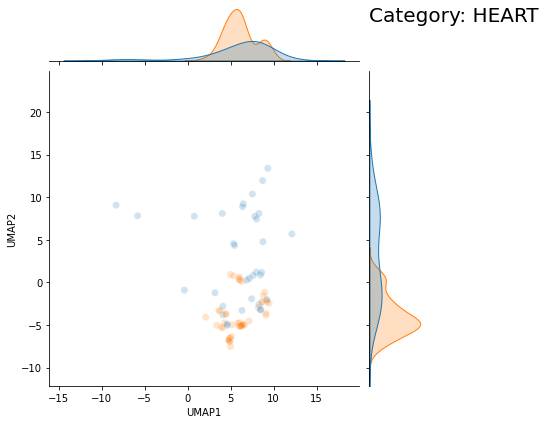

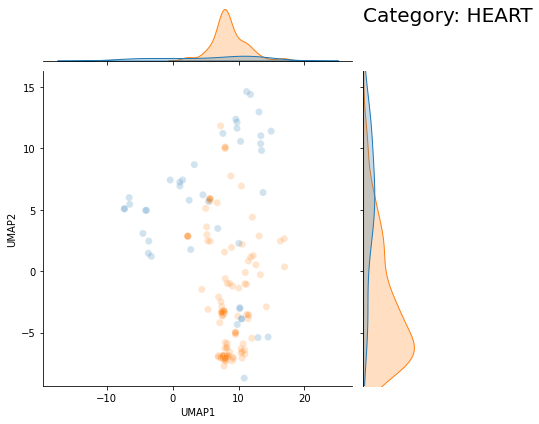

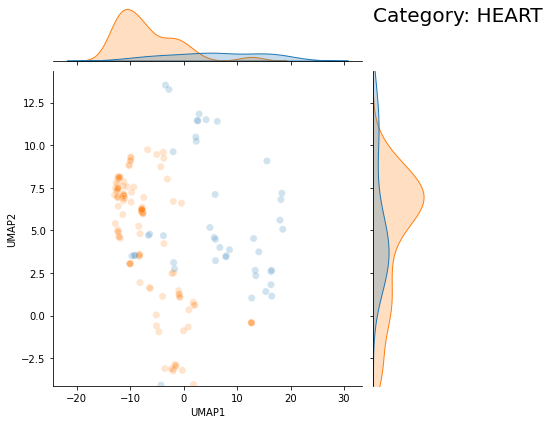

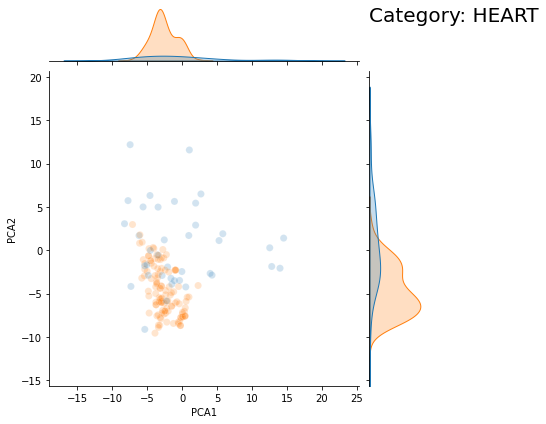

In [31]:
CAT =  'HEART' # 'INFLAM' # BLOOD, INFLAM, HEART, draw_hour
PALETTE = None # "Spectral"
alpha = 0.2
csize = 50
kind = 'scatter'

q=0.001

q1_05 = embedded_raw_df.UMAP1.quantile(q)
q1_95 = embedded_raw_df.UMAP1.quantile(1-q)
q2_05 = embedded_raw_df.UMAP2.quantile(q)
q2_95 = embedded_raw_df.UMAP2.quantile(1-q)
# generate subplots, 3 cols
sns.jointplot(data=embedded_raw_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"), 
              x='UMAP1', y='UMAP2', hue=CAT,
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)

q1_05 = embedded_full_df.UMAP1.quantile(q)
q1_95 = embedded_full_df.UMAP1.quantile(1-q)
q2_05 = embedded_full_df.UMAP2.quantile(q)
q2_95 = embedded_full_df.UMAP2.quantile(1-q)
sns.jointplot(data=embedded_full_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"), 
                x='UMAP1', y='UMAP2', hue=CAT,
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)

q1_05 = embedded_full_update_df.UMAP1.quantile(q)
q1_95 = embedded_full_update_df.UMAP1.quantile(1-q)
q2_05 = embedded_full_update_df.UMAP2.quantile(q)
q2_95 = embedded_full_update_df.UMAP2.quantile(1-q)
sns.jointplot(data=embedded_full_update_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"),
                x='UMAP1', y='UMAP2', hue=CAT,
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)

q1_05 = embeddedPCA_full_update_df.PCA1.quantile(q)
q1_95 = embeddedPCA_full_update_df.PCA1.quantile(1-q)
q2_05 = embeddedPCA_full_update_df.PCA2.quantile(q)
q2_95 = embeddedPCA_full_update_df.PCA2.quantile(1-q)
sns.jointplot(data=embeddedPCA_full_update_df.dropna(subset=[CAT]).query(f"PCA1>{q1_05} & PCA1<{q1_95} \
                                                              & PCA2>{q1_05} & PCA2<{q1_95}"),
                x='PCA1', y='PCA2', hue=CAT, 
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)